In [136]:
%matplotlib inline

# Qualifying results overview

Plot the qualifying result with visualization the fastest times.


In [137]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import fastf1
import fastf1.plotting
from fastf1.core import Laps
import numpy as np
import matplotlib.patheffects as mpe



fastf1.Cache.enable_cache('./ff1cache')  # replace with your cache directory

# we only want support for timedelta plotting in this example
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)

quali = fastf1.get_session(2022, 2, 'R')
laps = quali.load_laps(False)
laps.to_pickle("./ff1cache/fastf1.pkl")
print(list(laps.columns))

core           INFO 	Loading laps for Saudi Arabian Grand Prix - Race [v2.1.6]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 19 drivers: ['11', '16', '55', '1', '31', '63', '14', '77', '10', '20', '4', '24', '18', '3', '44', '23', '27', '6', '']


['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'Compound', 'TyreLife', 'FreshTyre', 'LapStartTime', 'Team', 'Driver', 'TrackStatus', 'IsAccurate']


In [138]:
#Get the columns we need

First, we need to get an array of all drivers.



In [139]:
drivers = pd.unique(laps['Driver'])
print(drivers)

['PER' 'LEC' 'SAI' 'VER' 'OCO' 'RUS' 'ALO' 'BOT' 'GAS' 'MAG' 'NOR' 'ZHO'
 'STR' 'RIC' 'HAM' 'ALB' 'HUL' 'LAT']


<ipython-input-140-362e8aa669ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptime_vs_tire.dropna(0,inplace=True)


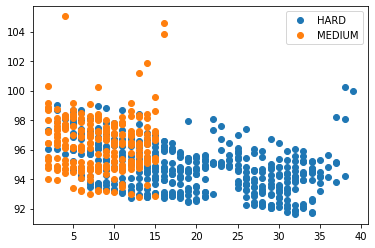

In [140]:
laptime_vs_tire = laps[["LapTime", "Compound", "TyreLife"]]
laptime_vs_tire.dropna(0,inplace=True)
grouped_laptime_vs_tire = [y for x,y in laptime_vs_tire.groupby("Compound",as_index=False)]

average_laptime = laptime_vs_tire["LapTime"].mean()
maximum_laptime = 1.07*average_laptime

fig, ax = plt.subplots()
for group in grouped_laptime_vs_tire:
    compound = group.iloc[0]["Compound"]
    group = group[group["LapTime"]<=maximum_laptime]
    if (compound == "INTERMEDIATE"):
        continue
    
    
    #print(z)
   # print(z(group["TyreLife"]))
    laptimes = (group["LapTime"] / np.timedelta64(1, 's')).to_numpy()
    tyrelife = group["TyreLife"].to_numpy()

    # z = np.polynomial.polynomial.polyfit(tyrelife, laptimes, 1)
    # z2 = [z[1], z[0]]
    # print(z)
    # p = np.poly1d(z2)

    plt.plot(tyrelife, laptimes, 'o', label = compound)
    # x = np.arange(2,25)
    # plt.plot(x, p(x),"--", label = compound)
plt.legend()
plt.show()




After that we'll get each drivers fastest lap, create a new laps object
from these laps, sort them by lap time and have pandas reindex them to
number them nicely by starting position.



<ipython-input-141-cb1ec41296bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laptime_vs_tire.dropna(0,inplace=True,subset=["LapTime"])


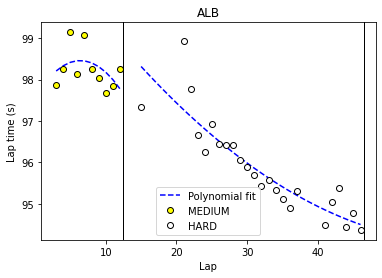

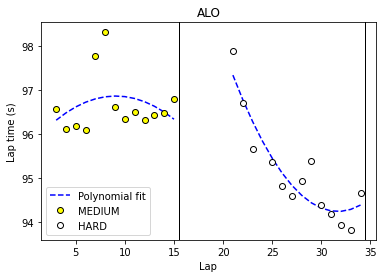

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


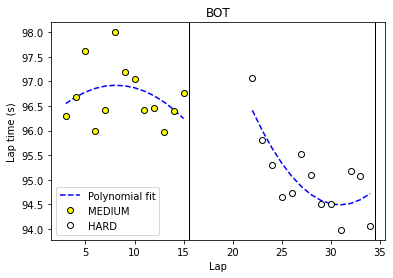

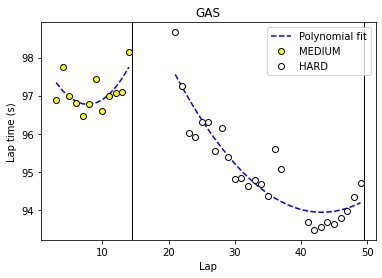

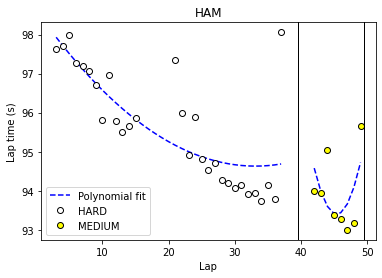

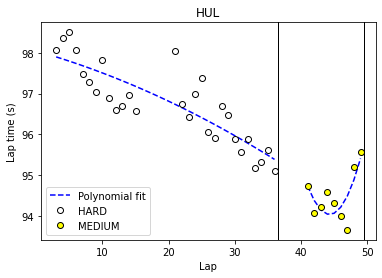

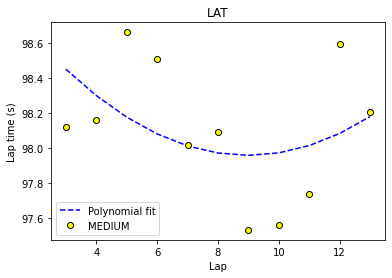

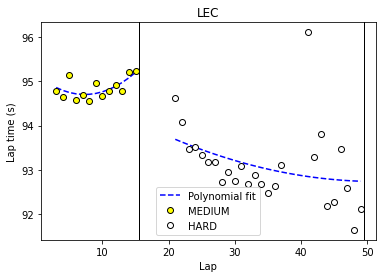

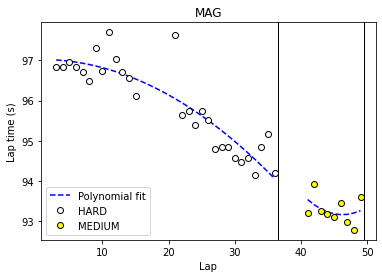

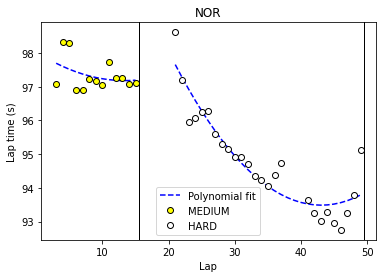

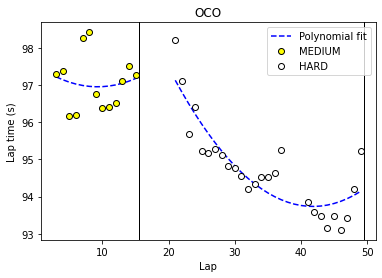

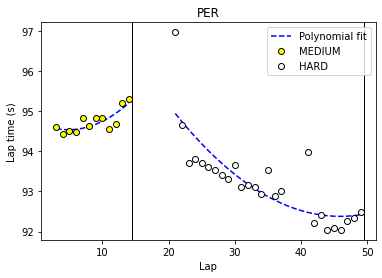

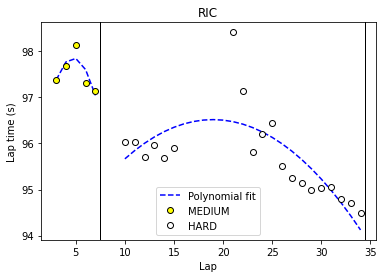

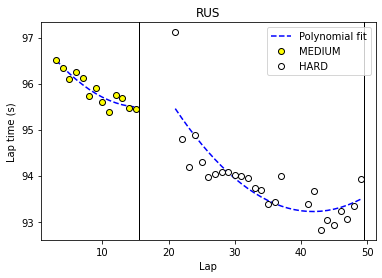

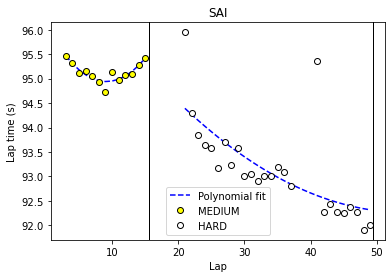

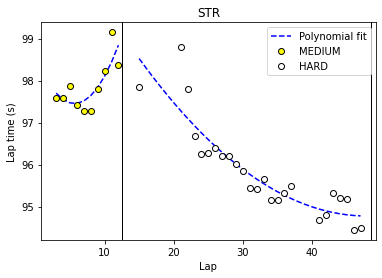

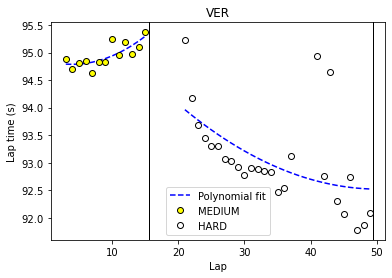

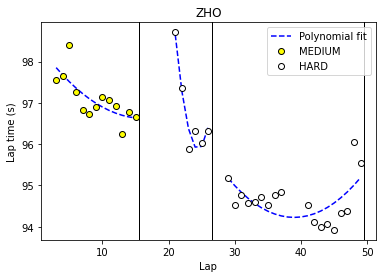

In [141]:
laptime_vs_tire = laps[["LapNumber","LapTime", "Compound", "TyreLife", "Driver", "Stint"]]
laptime_vs_tire.dropna(0,inplace=True,subset=["LapTime"])

grouped_by_driver = [y for x,y in laptime_vs_tire.groupby("Driver",as_index=False)]

for driver in grouped_by_driver:
    grouped_laptime_vs_tire = [y for x,y in driver.groupby("Stint",as_index=False)]
    
    

    fig, ax = plt.subplots()
    plt.title(driver.iloc[0]["Driver"])

    for group in grouped_laptime_vs_tire:
        compound = group.iloc[0]["Compound"]

        group["LapTimeSeconds"] = (group["LapTime"] / np.timedelta64(1, 's'))
        #remove outlap and inlap
        group.drop(group.tail(1).index,inplace=True) # drop last n rows       
        group.drop(group.head(1).index,inplace=True) # drop first n rows

        laptimes = group["LapTimeSeconds"].to_numpy()
        average_laptime = np.median(laptimes)
        maximum_laptime = 1.07*average_laptime
        
        group = group[group["LapTimeSeconds"]<=maximum_laptime]
        
        laptimes = group["LapTimeSeconds"].to_numpy()
        lapnumbers = group["LapNumber"].to_numpy()

        if (len(lapnumbers) > 0):

            z = np.polynomial.polynomial.polyfit(lapnumbers, laptimes, 2)
            z2 = np.flip(z)
            p = np.poly1d(z2)
            if (compound == "SOFT"):
                color = "red"
            elif compound == "MEDIUM":
                color = "yellow"
            elif compound == "HARD":
                color = "white"
            else:
                color = "green"

            x = np.arange(lapnumbers[0],lapnumbers[-1]+1)
            plt.plot(x, p(x),"--", color= "blue",label="Polynomial fit")

            plt.plot(lapnumbers, laptimes, 'o', label = compound, color = color, mec="black")
        
    
    
    for group in grouped_laptime_vs_tire:
        ylim = ax.get_ylim()
        lapnumbers = group["LapNumber"].to_numpy()

        if len(lapnumbers) > 0:
            ax.axvline(lapnumbers[-1]+0.5,0,1,color="black", linewidth = 1)

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
       if l not in lablout:
            lablout.append(l)
            handout.append(h)
    plt.legend(handout, lablout)
    plt.xlabel("Lap")
    plt.ylabel("Lap time (s)")
    plt.show()


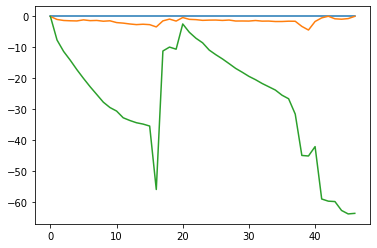

In [142]:
relative_driver = "LEC"

laptime_vs_tire = laps[["LapNumber","LapTime", "Compound", "TyreLife", "Driver", "Stint","LapStartTime"]]

drivers = laps["Driver"].unique()
driver_deltas = pd.DataFrame(columns=drivers)

grouped_by_driver = [y for x,y in laptime_vs_tire.groupby("Driver",as_index=False)]

relative_driver_laps = laptime_vs_tire[laptime_vs_tire["Driver"]==relative_driver]
relative_driver_laps = relative_driver_laps[["LapNumber","LapStartTime"]]

for driver in grouped_by_driver:
    driverName = driver.iloc[0]["Driver"]
    driver = driver[["LapNumber","LapStartTime"]]
    merged_df = pd.merge(relative_driver_laps,driver,on="LapNumber",how="inner")
    merged_df.reset_index()
    driver_deltas[driverName] =(merged_df["LapStartTime_x"]-merged_df["LapStartTime_y"])/ np.timedelta64(1, 's')

plt.plot(driver_deltas["LEC"])
plt.plot(driver_deltas["VER"])
plt.plot(driver_deltas["HAM"])
plt.show()


21.812263157894737 21.441 3.2243731474359194
18.205 24.857


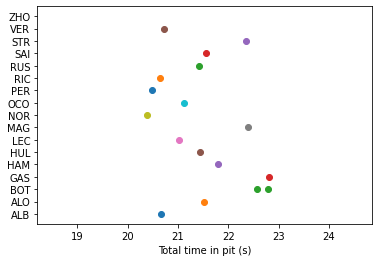

In [147]:
laptime_vs_tire = laps[["LapNumber","LapTime", "Compound", "TyreLife", "Driver", "Stint","LapStartTime","PitOutTime","PitInTime"]]

grouped_by_driver = [y for x,y in laptime_vs_tire.groupby("Driver",as_index=False)]
fig,ax = plt.subplots()
all_pitstops = []
driver_i = 1
for driver in grouped_by_driver:
    driverName = driver.iloc[0]["Driver"]
    driver["PitInTime"] = driver["PitInTime"].shift(1)
    
    driver.dropna(inplace=True,subset=["PitInTime","PitOutTime"])
    
    driver["TotalPitTime"] = (driver["PitOutTime"]-driver["PitInTime"])/np.timedelta64(1, 's')
    if len(driver["TotalPitTime"]) > 0:
        plt.plot(driver["TotalPitTime"],[driverName]*len(driver["TotalPitTime"]),'o',label=driverName)
        driver_i = driver_i+1
        for time in driver["TotalPitTime"].to_numpy():
            all_pitstops.append(time)
    # else:
    #     print(driverName)
    #     print(driver)


mean_pitstop = np.mean(all_pitstops)
print(np.mean(all_pitstops), np.median(all_pitstops), np.std(all_pitstops))
iqr = np.subtract(*np.percentile(all_pitstops, [75, 25]))
lower_q = np.percentile(all_pitstops, 25) - 1.5*iqr
upper_q = np.percentile(all_pitstops, 75) + 1.5*iqr

print(lower_q, upper_q)
left,right = plt.xlim()
plt.xlim([lower_q,upper_q])
plt.xlabel("Total time in pit (s)")
plt.show()


    



Undercut threats:  SAI,PER


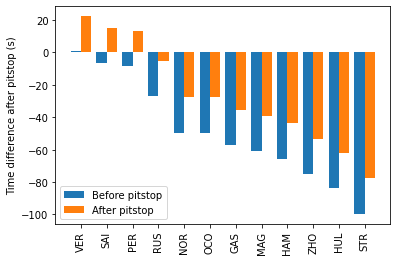

In [206]:
relative_driver = "LEC"
lap = 49

laptime_vs_tire = laps[["LapNumber","LapTime", "Compound", "TyreLife", "Driver", "Stint","LapStartTime"]]

drivers = laps["Driver"].unique()
drivers = np.insert(drivers,0,"LapNumber")
driver_deltas = pd.DataFrame()

grouped_by_driver = [y for x,y in laptime_vs_tire.groupby("Driver",as_index=False)]

relative_driver_laps = laptime_vs_tire[laptime_vs_tire["Driver"]==relative_driver]
relative_driver_laps = relative_driver_laps[["LapNumber","LapStartTime"]]
driver_deltas["LapNumber"] = relative_driver_laps["LapNumber"]
for driver in grouped_by_driver:
    driverName = driver.iloc[0]["Driver"]
    driver = driver[["LapNumber","LapStartTime"]]
    merged_df = pd.merge(relative_driver_laps,driver,on="LapNumber",how="inner")
    merged_df[driverName] =(merged_df["LapStartTime_x"]-merged_df["LapStartTime_y"])/ np.timedelta64(1, 's')
    merged_df = merged_df[["LapNumber",driverName]]
    driver_deltas = pd.merge(driver_deltas,merged_df,on="LapNumber",how="left")
driver_deltas_lap = driver_deltas[driver_deltas["LapNumber"] == lap]

undercut_threats = driver_deltas_lap[driver_deltas_lap < 0]
undercut_threats = undercut_threats[undercut_threats > -10]
undercut_threats.dropna(axis=1,inplace=True)
undercut_threats_names = list(undercut_threats.columns)[::-1]
print("Undercut threats: ", ",".join(undercut_threats_names))

driver_deltas_after_pitstop = driver_deltas_lap + mean_pitstop

drivers = []
values_before = []
values_after = []
fig, ax = plt.subplots()

for driver, value in driver_deltas_lap.items():
    if driver != "LapNumber" and relative_driver != driver:
        drivers.append(driver)
        values_before.append(value.iloc[0])

for driver, value in driver_deltas_after_pitstop.items():
    if driver != "LapNumber" and relative_driver != driver:
        values_after.append(value.iloc[0])
drivers = np.array(drivers)
values_before = np.array(values_before)
values_after = np.array(values_after)
p = (-values_before).argsort()
drivers = drivers[p]
values_before = values_before[p]
values_after = values_after[p]
plt.xticks(rotation=90)
plt.ylabel("Time difference after pitstop (s)")
plt.bar(drivers,values_before,label="Before pitstop",width = -0.4, align="edge")
plt.bar(drivers, values_after, label = "After pitstop", width= 0.4,align="edge")
plt.legend()